In [206]:
import pandas as pd
import re
import string
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
import matplotlib.pyplot as plt
import sys
from time import time
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from wordcloud import WordCloud
%matplotlib inline

In [207]:
new_df = pd.read_csv("CNN_Articels_clean.csv")
new_df.columns = new_df.columns.str.replace(' ','_')
new_df.columns = new_df.columns.str.strip().str.lower()
new_df = new_df.rename(columns={'article_text': 'text', 'category': 'cat'})

In [208]:
news_cat = ["politics", "health", "sport"]
rel_cat_df = new_df[new_df['cat'].isin(news_cat)]

In [209]:
df = rel_cat_df[['text', 'cat']]

In [210]:
df.head()

,text,cat
30,(CNN)The US public and even some health exper...,health
31,(CNN)A month after the US Food and Drug Admin...,health
32,(CNN)The number of deaths in the US involving...,health
33,(CNN)With a new version of the Omicron corona...,health
64,(CNN)The Cleveland Browns have defended their...,sport


In [211]:
df.dropna(inplace=True)
df.drop_duplicates('text', inplace=True)
df['text'] = df['text'].map(lambda x: re.sub('[^\w\s]', '', x))
df['text'] = df['text'].str.replace('(CNN)','')
df['text'] = df['text'].str.replace('(CNN Business)','')

/Users/admin/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/admin/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/admin/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future 

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18541 entries, 30 to 37946
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18541 non-null  object
 1   cat     18541 non-null  object
dtypes: object(2)
memory usage: 434.6+ KB


In [213]:
df.head()

,text,cat
30,The US public and even some health experts ma...,health
31,A month after the US Food and Drug Administra...,health
32,The number of deaths in the US involving alco...,health
33,With a new version of the Omicron coronavirus...,health
64,The Cleveland Browns have defended their sign...,sport


In [214]:
df["cat"].value_counts()

sport       15523
politics     2461
health        557
Name: cat, dtype: int64

In [215]:
df = df.groupby("cat").head(500)

In [216]:
df["cat"].value_counts()

health      500
sport       500
politics    500
Name: cat, dtype: int64

In [217]:
# df['len_text'] = df['text'].apply(lambda x: len(x))
df.head()

,text,cat
30,The US public and even some health experts ma...,health
31,A month after the US Food and Drug Administra...,health
32,The number of deaths in the US involving alco...,health
33,With a new version of the Omicron coronavirus...,health
64,The Cleveland Browns have defended their sign...,sport


In [218]:
df["text"]

30       The US public and even some health experts ma...
31       A month after the US Food and Drug Administra...
32       The number of deaths in the US involving alco...
33       With a new version of the Omicron coronavirus...
64       The Cleveland Browns have defended their sign...
                              ...                        
8791     New York state reported that Thursday had the...
8848    Story highlightsWellwishers from 22 states rai...
8870    Story highlightsFlorida officials announce mor...
8962    Story highlightsThe uterus came from a decease...
8985    Story highlightsTeenager dies after being bitt...
Name: text, Length: 1500, dtype: object

In [219]:
def basic_preprocess_case(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text


def del_stop_words(text):

    stpw = stopwords.words('english')
    text1 = ""
    for word in word_tokenize(text):
        if word not in stpw and len(word) > 1:
            text1 = text1 + " " + word

    return text1

def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

def preprocess(text):
    text = basic_preprocess_case(text)
    text = del_stop_words(text)
    text = stemming(text)
    return text

In [220]:
df['lem'] = df['text'].apply(lambda x: preprocess(x))

In [221]:
df['lem']

30       us public even health expert may underestim c...
31       month us food drug administr delay key step t...
32       number death us involv alcohol jump 255 2019 ...
33       new version omicron coronaviru variant pick s...
64       cleveland brown defend sign embattl quarterba...
                              ...                        
8791     new york state report thursday highest singl ...
8848     stori highlightswellwish 22 state rais nearli...
8870     stori highlightsflorida offici announc nontra...
8962     stori highlightsth uteru came deceas organ do...
8985     stori highlightsteenag die bitten multipl tim...
Name: lem, Length: 1500, dtype: object

In [222]:
df.to_csv("cnn_1500.csv", index=False)

In [223]:
vect_tfidf = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=2)
X_trf = vect_tfidf.fit_transform(df['lem'])

In [224]:
X_trf

<1500x19670 sparse matrix of type '<class 'numpy.float64'>'
	with 469019 stored elements in Compressed Sparse Row format>

In [225]:
inertia = []
k_means = KMeans(n_clusters=8, max_iter=1000, random_state=121)
start_time = time()
k_means.fit(X_trf)
inertia.append(k_means.inertia_)
print("done in %0.3fs" % (time() - start_time))

done in 2.942s


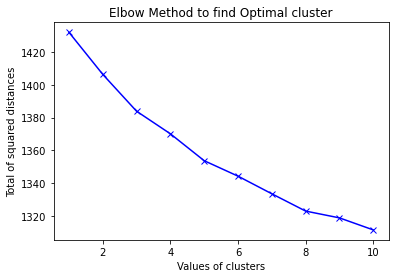

In [226]:
sum_of_sqrd_dist = []
num_total_clusters = range(1,11)
for num_clusters in num_total_clusters :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X_trf)
 sum_of_sqrd_dist.append(kmeans.inertia_)
plt.plot(num_total_clusters,sum_of_sqrd_dist,'bx-')
plt.xlabel('Values of clusters') 
plt.ylabel('Total of squared distances') 
plt.title('Elbow Method to find Optimal cluster')
plt.show()

In [228]:
labels = df.cat
print("Homogeneity index: %0.3f" % metrics.homogeneity_score(labels, k_means.labels_))
print("Completeness index: %0.3f" % metrics.completeness_score(labels, k_means.labels_))
print("V-measure index: %0.3f" % metrics.v_measure_score(labels, k_means.labels_))
print("Adjusted Rand-Index index: %.3f"
      % metrics.adjusted_rand_score(labels, k_means.labels_))
print("Silhouette Coefficient index: %0.3f"
      % metrics.silhouette_score(X_trf, k_means.labels_))

Homogeneity index: 0.748
Completeness index: 0.434
V-measure index: 0.549
Adjusted Rand-Index index: 0.435
Silhouette Coefficient index: 0.027


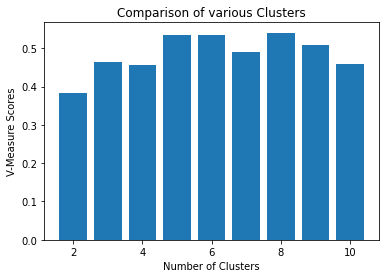

In [227]:
from sklearn.metrics import homogeneity_completeness_v_measure

scores = []

N_Clusters = [2, 3, 4, 5, 6 ,7, 8, 9 ,10]

for i in N_Clusters:
    kmeans2 = KMeans(n_clusters = i, max_iter=1000, random_state=111)
    kmeans2.fit(X_trf)
    labels2 = kmeans2.predict(X_trf)
    scores.append(v_measure_score(df['cat'], labels2))
    

plt.bar(N_Clusters, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('V-Measure Scores')
plt.title('Comparison of various Clusters')
plt.show()

In [122]:
# Largest centroids -> descending pattern:
centroids = k_means.cluster_centers_.argsort()[:, ::-1] 
features = vect_tfidf.get_feature_names_out()
for i in range(8):
    print("Cluster %d ->" % i, end='')
    for j in centroids[i, :10]:
        print(' %s' % features[j], end='')
    print()

Cluster 0 -> race hors formula caption hamilton photo driver car ascot verstappen
Cluster 1 -> said peopl health say famili like patient children studi year
Cluster 2 -> vaccin covid19 dose variant mask test omicron booster health cdc
Cluster 3 -> club leagu footbal player neymar barcelona champion chelsea psg manchest
Cluster 4 -> biden trump presid said hous capitol white democrat administr state
Cluster 5 -> russia ukrain russian putin biden sanction ukrainian offici war zelenski
Cluster 6 -> elect democrat vote republican court trump voter state senat biden
Cluster 7 -> olymp athlet game winter sport golf medal team gold win


In [229]:
while True:
    search_input = input()
    search_input = preprocess(search_input)
    print(search_input, vect_tfidf.transform([search_input]))
    res = k_means.predict(vect_tfidf.transform([search_input]))
#     print(res)
    print("this search input is in",res[0], "cluster")

power of the sun The biennial race was first held in 1987 and last years edition drew 24 teams from across the globeThe competition was split into three different classes with driving from 8 am until 5 pmRead MoreThe race takes between five and six days Visit comsport for more news features and videosBelgian team Agoria finished first in one class” that belongs to 0
 power sun biennial race first held 1987 last year edit drew 24 team across globeth competit split three differ class drive pmread moreth race take five six day visit comsport news featur videosbelgian team agoria finish first one class belong   (0, 19512)	0.06511502549845562
  (0, 18718)	0.13011752815556032
  (0, 17122)	0.2032470962293408
  (0, 16809)	0.21977331286206941
  (0, 16303)	0.20401986229063632
  (0, 13911)	0.258236258243861
  (0, 13427)	0.1250065535721189
  (0, 11880)	0.10525319756721759
  (0, 11476)	0.1538413224686609
  (0, 8182)	0.13833558683462752
  (0, 7535)	0.3569293111206031
  (0, 6806)	0.13813731574904908


KeyboardInterrupt: Interrupted by user

In [ ]:
stop_words = stopwords.words('english')

most_words = '' 
stopwords = set(stop_words) 
  
for value in df['text']: 
    value = str(value) 
    tokens = value.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    most_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 745, height = 745, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 9).generate(most_words)
plt.figure(figsize = (8,8), facecolor = None) 
plt.axis("off") 
plt.imshow(wordcloud) 
plt.show()